# Nanopore Adenocarcinoma Binary Classification
Andrew E. Davidson  
aedavids@ucsc.edu  
4/24/24  

Copyright (c) 2020-2023, Regents of the University of California All rights reserved. 
https://polyformproject.org/licenses/noncommercial/1.0.0

ref: extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/elifeBinaryRandomForestResults.ipynb

In [1]:
import ipynbname

# use display() to print an html version of a data frame
# useful if dataFrame output is not generated by last like of cell
from IPython.display import display

import joblib
# import math
# import numpy as np
import os
import pandas as pd
pd.set_option('display.max_rows', None)
# import pprint as pp
import matplotlib.pyplot as plt

# import scikitplot as skplt

from sklearn.ensemble        import RandomForestClassifier

# from sklearn.metrics import roc_curve
# from sklearn.metrics import roc_auc_score

# from sklearn.model_selection import cross_val_score, cross_validate
# from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.tree import plot_tree

import sys

notebookName = ipynbname.name()
notebookPath = ipynbname.path()
notebookDir = os.path.dirname(notebookPath)

# #outDir = f'{notebookDir}/{notebookName}.out'
# outDir = f'/private/groups/kimlab/aedavids/elife/{notebookName}.out'
# os.makedirs(outDir, exist_ok=True)
# print(f'outDir:\n{outDir}')

# modelOutDir = os.path.join(outDir, "model")
# os.makedirs(modelOutDir, exist_ok=True)
# print(f'\nmodelOutDir ;\n{modelOutDir}')

# # results of hyperparmeter search
# hyperparameterOut = "/private/groups/kimlab/aedavids/elife/hyperparmeterTunning"

# imgOut = f'{outDir}/img'
# os.makedirs(imgOut, exist_ok=True)
# print(f'\nimgOut :\n{imgOut}')

import logging
#loglevel = "INFO"
loglevel = "WARN"
# logFMT = "%(asctime)s %(levelname)s [thr:%(threadName)s %(name)s %(funcName)s() line:%(lineno)s] [%(message)s]"
logFMT = "%(asctime)s %(levelname)s %(name)s %(funcName)s() line:%(lineno)s] [%(message)s]"
logging.basicConfig(format=logFMT, level=loglevel)    
logger = logging.getLogger(notebookName)

meaningOfLife = 42

/data/tmp/ipykernel_107476/3176722482.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# ! pwd
# ! ls ../../intraExtraRNA_POC/python/src

In [3]:
# setting the python path allows us to run python scripts from using
# the CLI. 
ORIG_PYTHONPATH = os.environ['PYTHONPATH']

deconvolutionModules = notebookPath.parent.joinpath("../../deconvolutionAnalysis/python/")
print("deconvolutionModules: {}\n".format(deconvolutionModules))

PYTHONPATH = ORIG_PYTHONPATH + f':{deconvolutionModules}'
print("PYTHONPATH: {}\n".format(PYTHONPATH))

intraExtraRNA_POCModules=notebookPath.parent.joinpath(" ../../intraExtraRNA_POC/python/src")
print("intraExtraRNA_POCModules: {}\n".format(intraExtraRNA_POCModules))

PYTHONPATH = PYTHONPATH + f':{intraExtraRNA_POCModules}'
print("PYTHONPATH: {}\n".format(PYTHONPATH))

os.environ["PYTHONPATH"] = PYTHONPATH
PYTHONPATH = os.environ["PYTHONPATH"]
print("PYTHONPATH: {}\n".format(PYTHONPATH))

# to be able to import our local python files we need to set the sys.path
# https://stackoverflow.com/a/50155834
sys.path.append( str(deconvolutionModules) )
sys.path.append( str(intraExtraRNA_POCModules) )
print("\nsys.path:\n{}\n".format(sys.path))

deconvolutionModules: /private/home/aedavids/extraCellularRNA/londonCalling2024/jupyterNotebooks/../../deconvolutionAnalysis/python

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/londonCalling2024/jupyterNotebooks/../../deconvolutionAnalysis/python

intraExtraRNA_POCModules: /private/home/aedavids/extraCellularRNA/londonCalling2024/jupyterNotebooks/ ../../intraExtraRNA_POC/python/src

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/londonCalling2024/jupyterNotebooks/../../deconvolutionAnalysis/python:/private/home/aedavids/extraCellularRNA/londonCalling2024/jupyterNotebooks/ ../../intraExtraRNA_POC/python/src

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/londonCalling2024/jupyterNotebooks/../../deconvolutionAnalysis/python:/private/home/aedavids/extraCellularRNA/londonCalling2024/jupyterNotebooks/ ../../intraExtraRNA_POC/python/src


sy

In [4]:
# import local 
# from analysis.utilities import findFile
from analysis.utilities import loadDictionary
from analysis.utilities import loadList
# from analysis.utilities import saveDictionary
# from intraExtraRNA.elifeUtilities import loadElifeTrainingData
# # from models.randomForestHyperparmeterSearch import createScoringMetricsDict
# # from models.randomForestHyperparmeterSearch import evaluateModel
# # # from models.randomForestHyperparmeterSearch import tunningFramework
# from models.plotROC import plotROC
# from pipeline.dataFactory.utilities import urlify

# load our pretrained random forest model

In [5]:
modelOut = "/private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out/model"
modelPath = f"{modelOut}/elife-Esophagus-Cancer-Health-control-random-forest-GTEx-Esophagus_Mucosa-biomarkers.joblib"
GTEx_Esophagus_Mucosa_rf_model = joblib.load(modelPath)
print(f'loaded model: {modelPath}')

loaded model: /private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out/model/elife-Esophagus-Cancer-Health-control-random-forest-GTEx-Esophagus_Mucosa-biomarkers.joblib


In [6]:
featureImportancePath = f"{modelOut}/elife-Esophagus-Cancer-Health-control-random-forest-GTEx-Esophagus_Mucosa-biomarkers_featureImportance.txt"
featureImportanceDict = loadDictionary( featureImportancePath )
featureImportanceDict

{'FAM135A': 0.1429227285236892,
 'NLRX1': 0.11574068238759797,
 'PGM2': 0.24153693246326127,
 'THOC3': 0.12429224367757673,
 'TXNDC17': 0.178950174805024,
 'USP6NL': 0.1050306785210011,
 'YOD1': 0.0915265596218498}

In [7]:
featureNamesPath = f"{modelOut}/elife-Esophagus-Cancer-Health-control-random-forest-GTEx-Esophagus_Mucosa-biomarkers_features.txt"
featureNames = loadList(featureNamesPath)
featureNames

['FAM135A',
 'YOD1',
 'THOC3',
 'USP6NL',
 'NLRX1',
 'TXNDC17',
 'PGM2',
 'DHRS1',
 'TTC7B',
 'PLD2']

In [8]:
# ! cat $featuresPath

In [9]:
GTEx_Esophagus_Mucosa_rf_model 

RandomForestClassifier(max_depth=5, max_features=5, max_samples=0.2,
                       n_estimators=50, random_state=42)

figure out what category the model expects

In [10]:
# print( dir(GTEx_Esophagus_Mucosa_rf_model) )
# print()
print(f'classes_ : {GTEx_Esophagus_Mucosa_rf_model.classes_}' )
print(f'n_features_in_ : {GTEx_Esophagus_Mucosa_rf_model.n_features_in_}')
print(f'n_outputs_ : {GTEx_Esophagus_Mucosa_rf_model.n_outputs_}')

classes_ : [0 1]
n_features_in_ : 7
n_outputs_ : 1


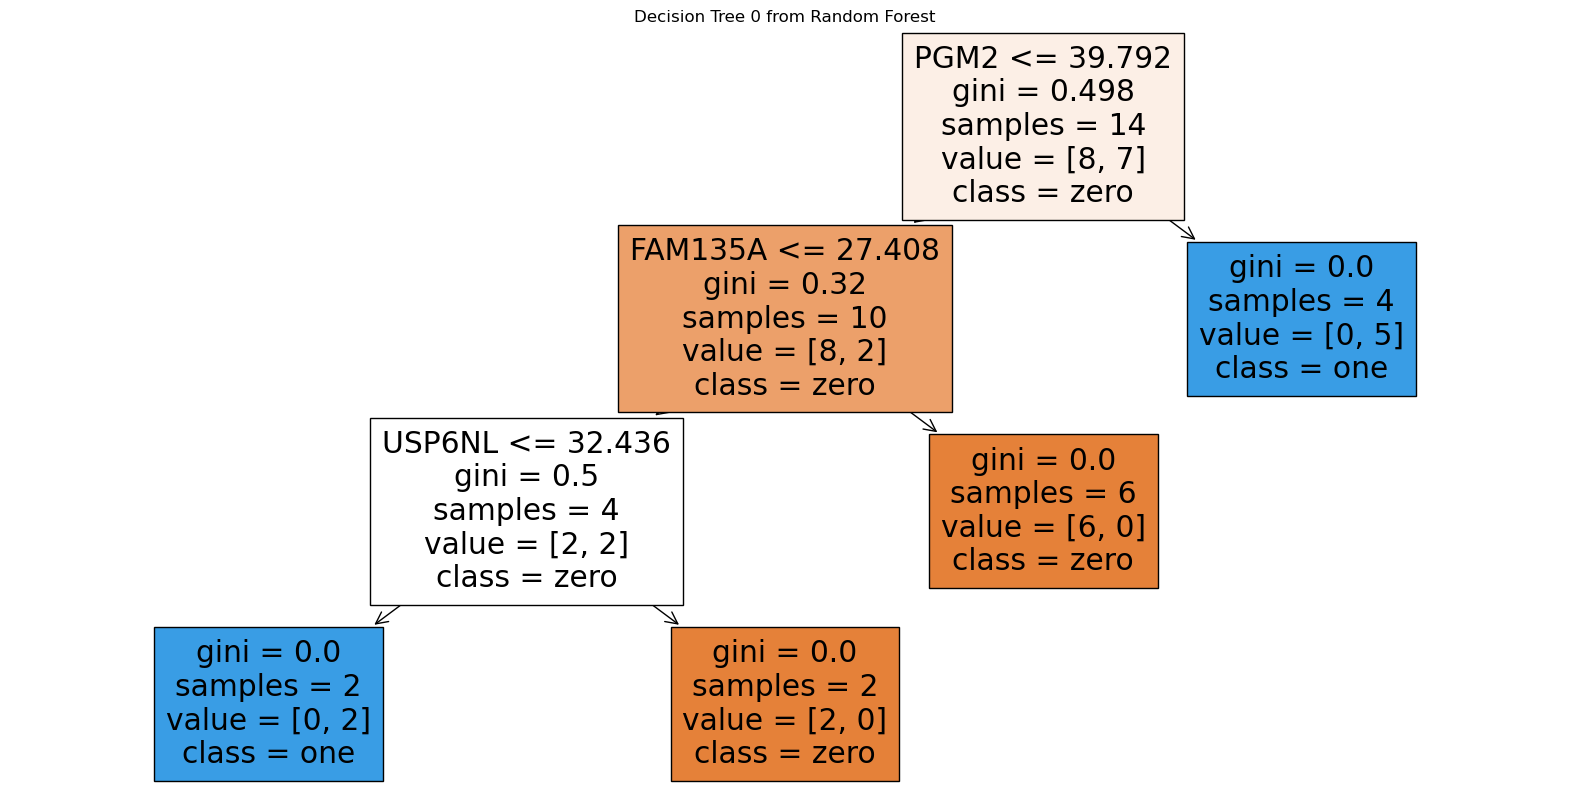

In [12]:
# Select one tree from the forest
tree_index = 0  # selecting the first tree
singleTree = GTEx_Esophagus_Mucosa_rf_model.estimators_[tree_index]

# Plot the selected tree
plt.figure(figsize=(20,10))
# plot_tree(singleTree, filled=True, feature_names=['sepal length', 'sepal width', 'petal length', 'petal width'], class_names=['Setosa', 'Versicolor', 'Virginica'])
plot_tree(singleTree, 
          filled=True, 
          feature_names=featureNames,
          class_names=['zero', 'one'],
          feature_names=aedwip,
         )
plt.title(f"Decision Tree {tree_index} from Random Forest")
plt.show()